In [1]:
# Notebook essentially plotting the signal for a mutlitude of different setups 
from cycler import cycler;
import matplotlib.pyplot as plt;
import numpy as np;
import scipy;
from scipy.constants import c;
import sys;
import time;
sys.path.insert(0, r'../../python/')
import phase_retard as pr;

# Colors for plotting.
plot_colors = ['#332288', '#88CCEE', '#44AA99', '#117733', '#999933', \
               '#DDCC77','#CC6677', '#882255',  '#AA4499'];

cy = cycler('color', plot_colors);


# Bunch parameters
Q_drive    = 1.5e-9;
sigz_drive = 5.2e-6;
sigt_drive = sigz_drive/c;
Q_wit      = 0.5e-9;
sigz_wit   = 5.2e-6;
sigt_wit   = sigz_wit/c;
del_z      = 175e-6;
del_t      = del_z/c;
x_drive    = 1.0e-3;
y_drive    = 0.0;
x_wit      = 1.0e-3;
y_wit      = 0.0;
r_drive    = np.sqrt(x_drive**2 + y_drive**2);
r_wit      = np.sqrt(x_wit**2 + y_wit**2);

drive      = {'Q':Q_drive, 'sig_t':sigt_drive, 'x' : x_drive, 'y' : y_drive};
wit        = {'Q':Q_wit, 'sig_t':sigt_wit, 'x' : x_wit, 'y' : y_wit};

# Crystal parameters (type and thickness)
ctype = 'GaP';
d   = 100e-6;
# Probe parameters
y0      = 800e-9;
a_laser = 0 * np.pi / 180;
z_match = 0;
tau     = np.linspace(-200, 800, 5000) * 1e-15;
probe = {'y0'     :y0, 
         'a_laser': a_laser, 
         'z_match': z_match, 
         'chirp'  : True,
         'width'  : 27e-9};

# time array for THz field
N         = 8000;
dt        = drive['sig_t']/10;
t         = np.linspace(- N * dt/2, N * dt/2, N);

# Compuatational parameters
nslice = int(d * 1e6);
base_params  = {'ctype'    : ctype, 
                't'       : t, 
                'tau'     : tau,
                'nslice'  : nslice,
                'beam1'   : drive,
                'beam2'   : wit,
                't_off'   : del_t,
                'plot'    : False,
                'verbose' : False, 
                'pockel'  : True, 
                'ref'     : True,
                'save'    : False,
                'probe'   : probe}; 

In [2]:
def plot_signal(gamma, gamma_drive, gamma_wit, det, t, r):
    fig = plt.figure(figsize = (6,6), dpi = 300);
    ax  = fig.gca();
    ax.set_prop_cycle(cy);
    if det == 'bal':
        ax.set_ylabel(r'sin$\Gamma$');
        combo = np.sin(gamma);
        drive = np.sin(gamma_drive);
        wit   = np.sin(gamma_wit);
    elif det == 'cross':
        ax.set_ylabel(r'sin$^2\frac{Gamma}{2}$');
        combo = np.sin(gamma / 2)**2;
        drive = np.sin(gamma_drive / 2)**2;
        wit   = np.sin(gamma_wit / 2)**2;
    else:
        ax.set_ylabel(r'$\Gamma$ [rad]');
        combo = gamma;
        drive = drive_gamma;
        wit   = wit_gamma;
    ax.plot(t, combo, '-', label = 'Combined');
    ax.plot(t, drive, '--', label = 'Drive');
    ax.plot(t, wit, '-.', label = 'Witness');
    
    ax.set_xlabel('t [fs]');
    ax.set_title('r = ' + str(r * 1e3) + ' mm');
    ax.legend();
    plt.show();

In [6]:
# Balanced detector 
def get_gammas():
    r_arr = np.arange(0.5, 3.1, 0.25) * 1e-3;
    params = base_params;

    params['det'] = 'cross';
    params['d'] = 100e-6;
    gamma = np.zeros((len(r_arr), len(params['tau'])));
    gamma_drive = np.zeros((len(r_arr), len(params['tau'])));
    gamma_wit   = np.zeros((len(r_arr), len(params['tau'])))
    for i in range(len(r_arr)):
        params['plot'] = True;
        r0 = r_arr[i];
        print(r0 * 1e3);
        params['beam1']['x'] = r0;
        params['beam2']['x'] = r0;
        gamma_drive[i, :], gamma_wit[i, :], gamma[i, :], t_plot = pr.phase_retard(params);
    return gamma_drive, gamma_wit, gamma, t_plot;
#gamma_drive, gamma_wit, gamma, t_plot = get_gammas();

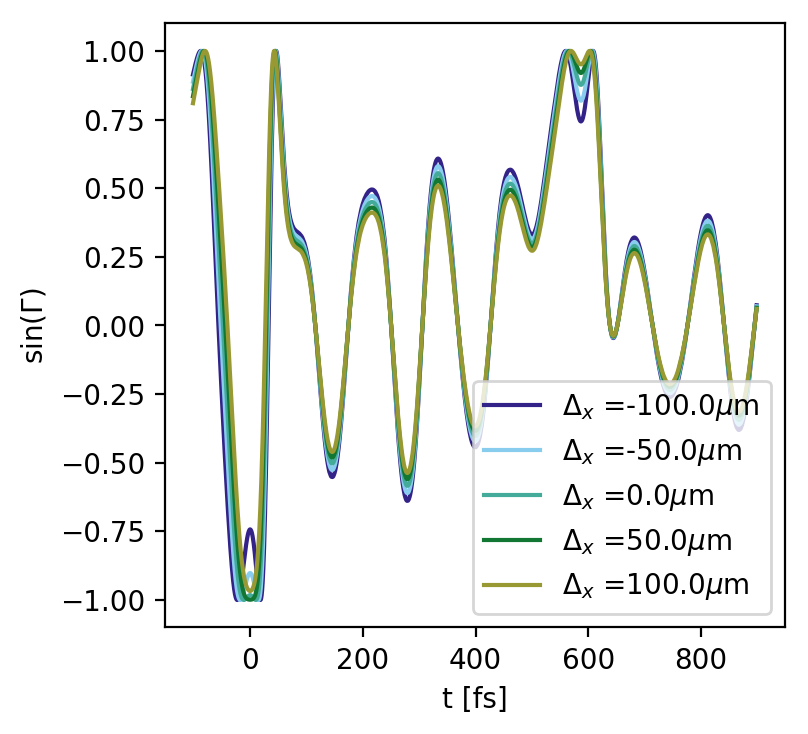

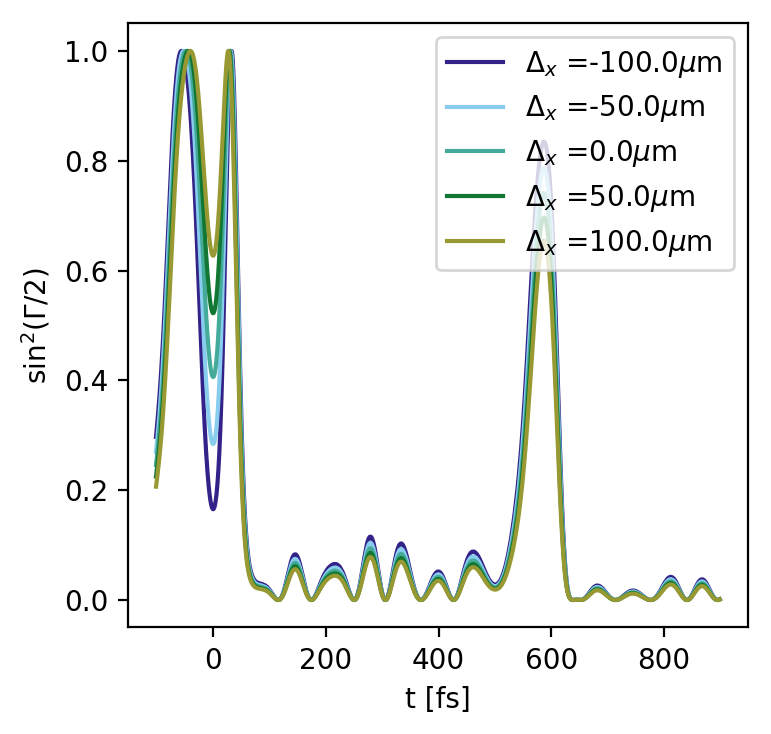

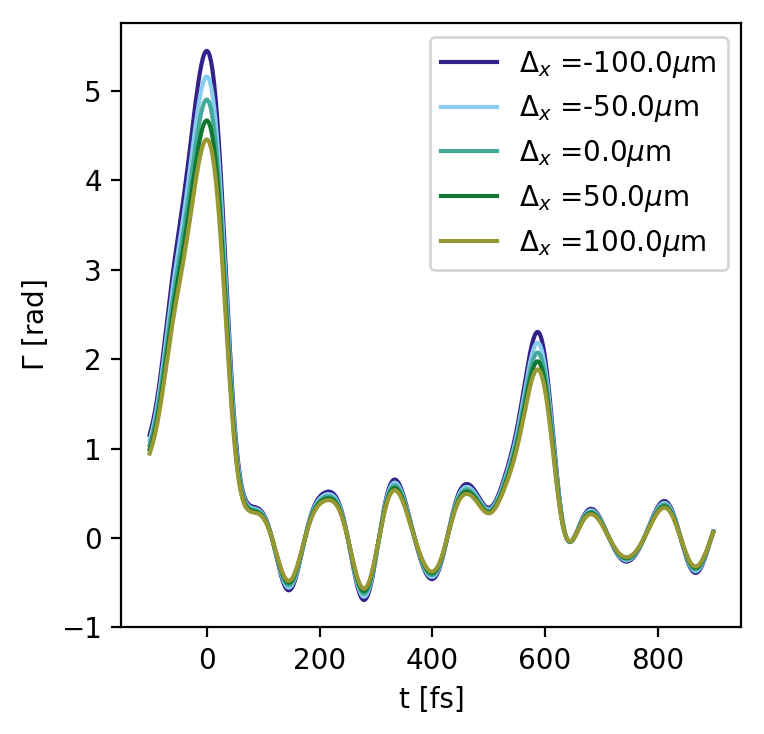

In [5]:
x_off = np.array([-100, -50, 0, 50, 100]) * 1e-6;
r0    = 1.0e-3;
params = base_params;
params['d'] = 100e-6;
gamma_offsets = np.zeros((len(x_off), len(tau)));
fig1 = plt.figure(figsize = (4,4), dpi = 200);
ax1  = fig1.gca();
ax1.set_xlabel('t [fs]');
ax1.set_ylabel(r'sin($\Gamma$)')
ax1.set_prop_cycle(cy);
fig2 = plt.figure(figsize = (4,4), dpi = 200);
ax2  = fig2.gca();
ax2.set_xlabel('t [fs]');
ax2.set_ylabel(r'sin$^2(\Gamma/2)$')
ax2.set_prop_cycle(cy);
fig3 = plt.figure(figsize = (4,4), dpi = 200)
ax3  = fig3.gca();
ax3.set_xlabel('t [fs]');
ax3.set_ylabel(r'$\Gamma$ [rad]')
ax3.set_prop_cycle(cy);
for i in range(len(x_off)):
    x  = np.round(x_off[i] * 1e6)
    params['beam1']['x'] = r0 + x_off[i];
    params['beam2']['x'] = r0 + x_off[i];
    dummy, dummy, gamma_offsets[i, :], dummy = pr.phase_retard(params);
    ax1.plot(t_plot, np.sin(gamma_offsets[i, :]), label = r'$\Delta_x$ =' + str(x) + r'$\mu$m');
    ax2.plot(t_plot, np.sin(gamma_offsets[i, :] / 2)**2,label = r'$\Delta_x$ =' + str(x) + r'$\mu$m');
    ax3.plot(t_plot, gamma_offsets[i,:], label = r'$\Delta_x$ =' + str(x) + r'$\mu$m')
ax1.legend();
ax2.legend();
ax3.legend();
plt.show();